# Principal Component Analysis of Quasar UV Spectra
by Nick Flinner, Zavier Kamath, Lily Yu -- April 28, 2025

## Introduction

Our work largely follows the work done in the paper: "A Principal Component Analysis of quasar UV spectra at z ≈ 3" by Paris et al. 2018. In this paper, Paris et al. perfrom a principal component analysis (PCA) on quasar spectrum in order to estimate the continuum of the quasar spectrum and study the Lyman-α forest.

**The Lyman-α Forest**

Lyman-α is a very prominent UV emission line occuring at λ = 1216 Å. This is the brightest part of the quasar spectrum. However, as these Lyman-α photons travel towards us, they are absorbed by the neutral hydrogen in the intergalactic medium (IGM). These show up in the quasar spectrum as deep absorption lines blueshifted from the actual Lyman-α emission line. More distant quasar have deeper forests because the Lyman-α photons have more IGM to travel through, and thus more possible absorbers. An example of the Lyman-α forest in one of the quasars that we are using can be seen in Figure 2.

**Continua vs. Spectra**

The spectra of an object shows flux vs. wavelength, which includes all of the emission/absorption lines, noise, and the continuum. The continuum is the general underlying shape of the spectrum, typically estimated as a power law. In theory, this should be a smooth line, but practically it is often not, depending on how you fit to the spectrum. In areas with large amounts of absorption, like the Lyman-α forest, having the continuum rather than the spectrum is very useful.

Finding the normalized flux in the Lyman-α forest from the quasar using, $\rm F_{transmitted} = F_{obs}~/~F_{cont}$ inside the wavelength range of the forest, where $\rm F_{obs}$ is the observed flux and $\rm F_{cont}$ is the unabsorbed continuum flux. These values can be used to constrain the properties of the IGM, and since the IGM is where most of the baryons at high redshift, also constrain the $\rm Ω_{b}$. These values are also useful in studying the ionization and reionization history of the universe.

**Paris et al. 2018**

In their paper, Paris et al. aim to estimate the continuum of the blue, Lyman-α forest region of the spectra by using the red region of the spectra. The particulars of this are described in the Methodology sections, but the goal is to find how $\rm <F_{transmitted}>$ in the Lyman-α forest evolves with redshift and see how well a PCA can be used to estimate the quasar continua.

## Our Data

We obtained our data via SQL query from the Sloan Digital Sky Survey (https://www.sdss4.org/science/quasar_stack/?utm_source=chatgpt.com). We used 69 high-quality, high SNR quasar spectra around z ~ 3 as our training set. These specific quasars were selected by Paris et al. and listed in table 1 of the Paris et al. 2018 paper. After using these higher-quality spectra to obtain a projection matrix that can compute the full spectrum continua given just the red side spectra, we use another 690 quasar spectra from z = 2.5 to z = 3.6 as our testing set and for our $\rm <F_{transmitted}>$ plot.

## Methodology

Before performing an analysis we need to shift the quasar spectra into their rest frames. We do this by dividing the wavelengths of the original spectra by (1+z) and then interpolating the result onto a standard grid of wavelengths between 1020 Angstroms and 2000 Angstroms.

To predict the blue, Lyman-α part of the continua, we find the first $m$ principle components of the full spectra and their weights, $c_{ij}$, using the whole rest wavelength range. Another $m$ principle components and their weights, $d_{ij}$, are found using only the red side of the spectrum ($1216 - 2000~Å$). This is done for the training set of quasars.

We use both sets of weights to create matrices of $N × m$ form where $C = c_{ij}$ and $D = d_{ij}$. By setting $C = D·M$ and solving for $M$, we create the $m × m$ projection matrix $M$ that can translate red side spectra weights into full continua weights. We can then apply this projection matrix to the red side weights of any test spectra to obtain the full continua weights. Once we have the full continua weights, we can multiply by the principal component vectors to reconstruct the full continua.

The methodology of only looking at the red side is important because the red side does not contain noise from the weak emission lines in the Lyman-α area of the spectra.

# IMPORT BLOCK

*   Import necessary modules
*   Read-in the 69 high-quality training quasars
*   Normalize all these quasars to the rest wavelength using $\rm λ_{rest} = λ_{obs}~/~(1 + z)$

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import skew
from google.colab import drive
import os
from astropy.io import fits

# Mount Google Drive
drive.mount('/content/drive')

# Construct the file path to your CSV file
file_path = os.path.join('/content/drive/My Drive', 'group_project_2', 'all_spectra.csv')

# Load the CSV of combined QSO spectra
df = pd.read_csv(file_path)

# Define the rest-frame wavelength grid
rest_wavelength_grid = np.arange(1020, 2000, 1.0)

# Initialize lists to store processed spectra and corresponding QSO names
flux_matrix = []
valid_qsos = []

# Get unique QSO identifiers
qso_names = df['QSO'].unique()

for qso in qso_names:
    sub = df[df['QSO'] == qso]

    # Extract observed wavelength and flux
    wave_obs = sub['wave'].values
    flux_obs = sub['flux'].values

    # Get the quasar's redshift
    z_qso = sub['redshift'].values[0]

    # Convert observed wavelengths to rest frame
    wave_rest = wave_obs / (1.0 + z_qso)

    # Check if the spectrum covers the desired rest-frame wavelength range
    if wave_rest.min() > rest_wavelength_grid[0] or wave_rest.max() < rest_wavelength_grid[-1]:
        continue

    # Interpolate flux onto the rest-frame wavelength grid
    try:
        f_interp = interp1d(wave_rest, flux_obs, kind='linear', bounds_error=False, fill_value=0.0)
        flux_on_grid = f_interp(rest_wavelength_grid)

        # Calculate skewness to detect inversion
        spectrum_skewness = skew(flux_on_grid)

        # If skewness is negative, flip the spectrum
        if spectrum_skewness < 0:
            flux_on_grid = -flux_on_grid

        # Append the corrected spectrum and QSO name to the lists
        flux_matrix.append(flux_on_grid)
        valid_qsos.append(qso)

    except Exception as e:
        print(f"Interpolation failed for {qso}: {e}")
        continue

# Convert the list of spectra to a NumPy array
X = np.array(flux_matrix)  # shape: (N_quasars, N_pixels)
print(f"Shape of final data matrix X: {X.shape}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape of final data matrix X: (69, 980)


# Perform PCA on training quasar spectra

Note that Paris uses 12 pcs.

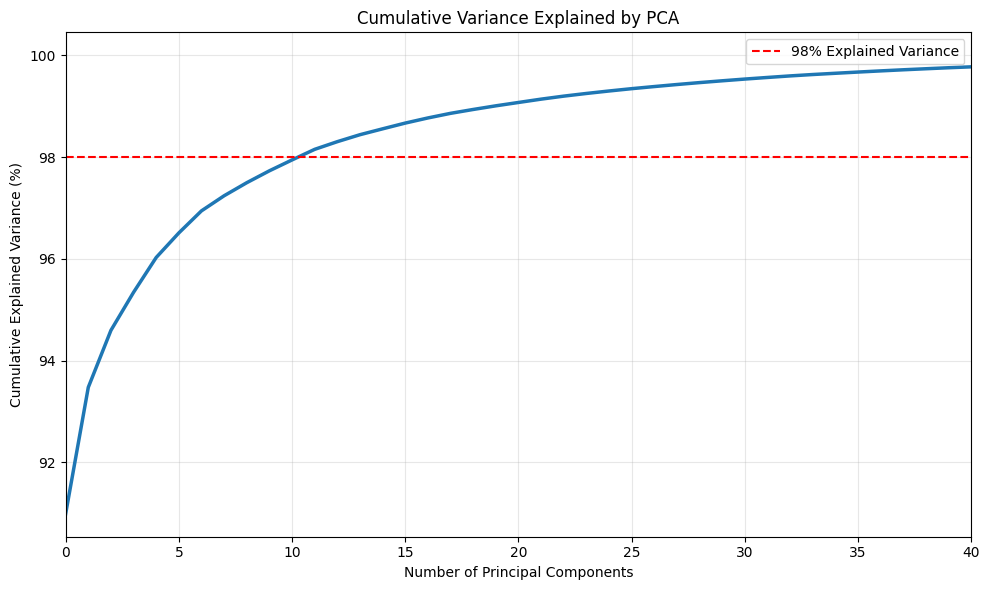

Number of components needed to explain 98% of variance: 12
This represents 17.39% of the original dimensions


In [ ]:

# GOAL OF THIS CODE BLOCK: Perform PCA on the training set and determine how many principal components to keep

# Step 1: Center the data
X = X.copy()
n_samples, n_features = X.shape
mean_spectrum = np.mean(X, axis=0)
X -= np.mean(X, axis=0)

# Step 2: SVD
U, S, Vt = np.linalg.svd(X, full_matrices=False)

# Step 3: Project
def svd2pca(U, S, Vt, n_pc=2):
    components = Vt[:n_pc]
    projected = U[:, :n_pc] * S[:n_pc]
    return projected, components, S

# Step 4: Explained variance
eigenvalues = (S**2) / n_samples
cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(cumulative_variance)), cumulative_variance * 100, linewidth=2.5)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Cumulative Variance Explained by PCA')
plt.grid(True, alpha=0.3)
plt.axhline(y=98, color='red', linestyle='--', label='98% Explained Variance')
plt.xlim(0, 40)
plt.legend()
plt.tight_layout()
plt.show()

# Number of components needed for 97% variance
n_components_98 = np.where(cumulative_variance >= 0.98)[0][0] + 1
print(f"Number of components needed to explain 98% of variance: {n_components_98}")
print(f"This represents {n_components_98/len(eigenvalues):.2%} of the original dimensions")



# Reconstruct the training continua with PCA

From our plot above, we see that 12 PCs are enough to explain about 98% of the variance. We will now reconstruct the spectrum using the principal component vectors that we found. Note that we have to add the mean back to get the full continuum estimate.

In [ ]:
# GOAL OF THIS CODE BLOCK: Reconstruct the spectra with the principal components that we decided on above. Create the continua by adding this reconstruction to the mean spectra. Plot an a example continua

# Let's say you keep n_pc components
n_pc = n_components_98

# Reconstruct centered spectra
X_reconstructed = (U[:, :n_pc] * S[:n_pc]) @ Vt[:n_pc, :]

# Add back the mean to get the full continuum estimate
continua = X_reconstructed + mean_spectrum

# Create the Projection Matrix

Perform PCA on the red side of the training spectra and then use red weights and full weights to obtain the projection matrix. We do this so that we can use the red side to compute the full continua.

In [ ]:
# GOAL OF THIS CODE BLOCK: Perform PCA on the red side of the training spectra and obtain the projection matrix.

# Mask for red side
red_mask = rest_wavelength_grid >= 1216
X_red = X[:, red_mask]
mean_red = np.mean(X_red, axis=0)

# Run PCA on red-side only
X_red_centered = X_red - mean_red
U_red, S_red, Vt_red = np.linalg.svd(X_red_centered, full_matrices=False)

# Project to n_pc dimensions
D = U_red[:, :n_pc] * S_red[:n_pc]    # red weights
C = U[:, :n_pc] * S[:n_pc]            # full weights

# Solve for projection matrix X in: C = D @ X
projection_matrix = np.linalg.lstsq(D, C, rcond=None)[0]

# Plot an example training continua

We plot an example continua we found from using PCA against the actual spectra of the quasar. We can qualitatively judge that our continua follow the general shape of the spectra with peaks on the red side, but tend to break down in the forest. We will see the consequences of this later on. This is the same as was done in Paris et al. Fig 3 if you would like to see a comparison (although Paris et al. hand-fit their continua).

✅ Plot saved as: paris_figure3_replica.png


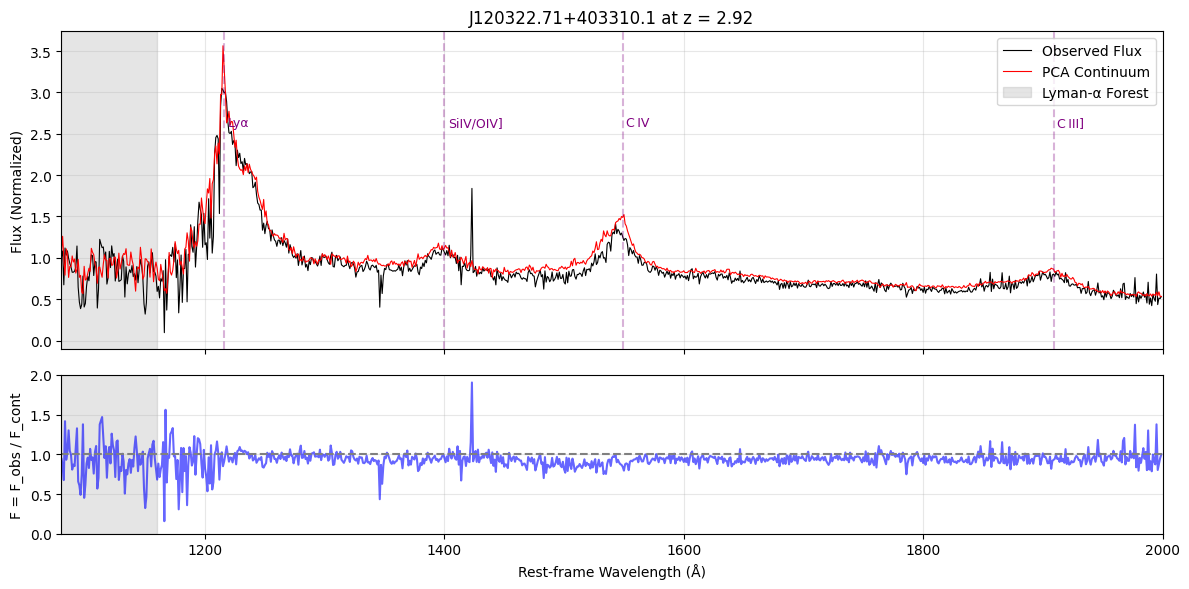

In [ ]:
def plot_named_training_qso_spectrum(qso_name, df, valid_qsos, X, continua, rest_wavelength_grid, save_path='training_qso_named_plot.png'):
    """
    Plot observed flux and PCA continuum for a named QSO in the training set.

    Parameters:
    - qso_name: str
    - df: original DataFrame from all_spectra.csv
    - valid_qsos: list of QSO names used in PCA training
    - X: flux matrix (normalized before PCA)
    - continua: reconstructed PCA continua (mean added)
    - rest_wavelength_grid: np.array of rest-frame wavelengths
    - save_path: path to save the plot
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import interp1d

    # Emission line labels
    emission_lines = {
        'Lyα': 1216,
        'SiIV/OIV]': 1400,
        'C IV': 1549,
        'C III]': 1909
    }

    # Find index
    try:
        idx = valid_qsos.index(qso_name)
    except ValueError:
        print(f"❌ QSO '{qso_name}' not in valid_qsos.")
        return

    # Extract observed flux
    sub = df[df['QSO'] == qso_name]
    wave_obs = sub['wave'].values
    flux_obs = sub['flux'].values
    z = sub['redshift'].values[0]

    # Interpolate observed flux to rest-frame grid
    wave_rest = wave_obs / (1.0 + z)
    f_interp = interp1d(wave_rest, flux_obs, kind='linear', bounds_error=False, fill_value=np.nan)
    obs_flux = f_interp(rest_wavelength_grid)

    # PCA continuum from training set (already normalized and mean added)
    continuum = continua[idx]

    # ✅ Normalize only the observed flux near 1280 Å
    norm_mask = (rest_wavelength_grid >= 1270) & (rest_wavelength_grid <= 1290)
    flux_norm = np.nanmedian(obs_flux[norm_mask])
    cont_norm = np.nanmedian(continuum[norm_mask])

    if not np.isfinite(flux_norm) or flux_norm <= 0:
        print(f"⚠️ Skipping {qso_name} due to bad normalization region.")
        return

    obs_flux /= flux_norm  # Normalize observed flux only
    continuum /= cont_norm  # Normalize continuum

    # Transmission (should hover around 1 in unabsorbed regions)
    F = obs_flux / continuum

    # Plot
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    axs[0].plot(rest_wavelength_grid, obs_flux, label="Observed Flux", color='black', linewidth=0.8)
    axs[0].plot(rest_wavelength_grid, continuum, label="PCA Continuum", color='red', linewidth=0.8)
    axs[0].axvspan(1080, 1160, color='gray', alpha=0.2, label="Lyman-α Forest")
    axs[0].set_ylabel("Flux (Normalized)")
    axs[0].set_title(f"{qso_name} at z = {z:.2f}")
    axs[0].legend()
    axs[0].grid(True, alpha=0.3)

    for name, wl in emission_lines.items():
        axs[0].axvline(wl, color='purple', linestyle='--', alpha=0.3)
        axs[0].text(wl + 3, np.nanmax(obs_flux) * 0.85, name, color='purple', fontsize=9)

    axs[1].plot(rest_wavelength_grid, F, color='blue', alpha=0.6)
    axs[1].axvspan(1080, 1160, color='gray', alpha=0.2)
    axs[1].axhline(1.0, color='gray', linestyle='--')
    axs[1].set_xlabel("Rest-frame Wavelength (Å)")
    axs[1].set_ylabel("F = F_obs / F_cont")
    axs[1].set_ylim(0, 2)
    axs[1].grid(True, alpha=0.3)

    plt.xlim(1080, 2000)
    plt.tight_layout()
    fig.savefig(save_path, dpi=300)
    print(f"✅ Plot saved as: {save_path}")
    plt.show()

# Call it as before
plot_named_training_qso_spectrum(
    'J120322.71+403310.1',
    df,
    valid_qsos,
    X,
    continua,
    rest_wavelength_grid,
    save_path="paris_figure3_replica.png"
)


# Read in the large quasar dataset and predict their continua using the projectiom matrix

This block filters BAL (Broad Absorpton Lines) and DLA (Damped Lyman-α systems) SDSS flags from our data and only keep spectra with S/N > 8 at 1280 Å. After applying these cuts, we find we have 690 good spectra to use. Using this data, we will predict their continua using the projection matrix we found with the training data.

In [ ]:
# Load large spectra CSV
file_path2 = os.path.join('/content/drive/My Drive', 'group_project_2', 'uniform_quasar_spectra.csv')
df_large = pd.read_csv(file_path2)
flux_cols = [col for col in df_large.columns if col.startswith('flux_')]
obs_wave = np.array([int(c.split('_')[1]) for c in flux_cols], dtype=float)

# Load DR16Q FITS catalog using THING_ID (as a proxy for specobjid)
file_path3 = os.path.join('/content/drive/My Drive', 'group_project_2', 'DR16Q_v4.fits')
with fits.open(file_path3) as hdul:
    data = hdul[1].data

    # Fix byte order for NumPy 2.0+ safely
    thing_id = data['THING_ID'].byteswap().view(data['THING_ID'].dtype.newbyteorder('='))
    bi_civ = data['BI_CIV'].byteswap().view(data['BI_CIV'].dtype.newbyteorder('='))
    nhi_dla = data['NHI_DLA'].byteswap().view(data['NHI_DLA'].dtype.newbyteorder('='))

    # Build DR16Q DataFrame
    df_dr16q = pd.DataFrame({
        'specobjid': thing_id,   # Match df_large
        'BI_CIV': bi_civ
    })

    # Add flags
    df_dr16q['BAL_FLAG'] = df_dr16q['BI_CIV'] > 0
    df_dr16q['DLA_FLAG'] = [np.any(np.log10(row) > 20.3) for row in nhi_dla]

# Merge flags into df_large
df_large = pd.merge(df_large, df_dr16q[['specobjid', 'BAL_FLAG', 'DLA_FLAG']], on='specobjid', how='left')
df_large['BAL_FLAG'] = df_large['BAL_FLAG'].fillna(False).astype(bool)
df_large['DLA_FLAG'] = df_large['DLA_FLAG'].fillna(False).astype(bool)

# Filter out BALs and DLAs
df_large = df_large[(~df_large['BAL_FLAG']) & (~df_large['DLA_FLAG'])].reset_index(drop=True)
print(f"✅ After BAL/DLA filtering: {df_large.shape[0]} quasars")

# Define rest-frame wavelength grid and S/N cut region
rest_wavelength_grid = np.arange(1020, 2000, 1.0)
sn_region = (rest_wavelength_grid >= 1275) & (rest_wavelength_grid <= 1285)

predicted_continua = []
spec_ids = []

# Loop through spectra
for idx, row in df_large.iterrows():
    flux = row[flux_cols].values.astype(float)
    z = row['redshift']
    spec_id = row['specobjid']

    if np.all(flux == flux[0]) or np.isnan(flux).any():
        continue

    wave_rest = obs_wave / (1.0 + z)

    if wave_rest.min() > 1150 or wave_rest.max() < 2000:
        continue

    try:
        f_interp = interp1d(wave_rest, flux, kind='linear', bounds_error=False, fill_value=0.0)
        flux_rest = f_interp(rest_wavelength_grid)
    except Exception as e:
        print(f"Skipping {spec_id} due to interp error: {e}")
        continue

    # S/N cut near 1280 Å
    red_window = flux_rest[sn_region]
    signal = np.nanmean(red_window)
    noise = np.nanstd(red_window)
    if not np.isfinite(signal) or not np.isfinite(noise) or noise <= 0 or (signal / noise < 8):
        continue

    # ✅ Normalize flux near 1280 Å before projection
    #norm_val = np.nanmedian(flux_rest[sn_region])
    #if not np.isfinite(norm_val) or norm_val <= 0:
    #    continue
    #flux_rest /= norm_val

    # PCA-based projection
    red_mask = rest_wavelength_grid >= 1216
    flux_red = flux_rest[red_mask]

    if len(flux_red) != len(mean_red):
        print(f"Length mismatch for red-side flux at {spec_id}")
        continue

    flux_red_centered = flux_red - mean_red
    b = flux_red_centered @ Vt_red[:n_pc].T
    a = b @ projection_matrix
    continuum = mean_spectrum + (a @ Vt[:n_pc])

    predicted_continua.append(continuum)
    spec_ids.append(spec_id)

print(f"✅ Total predicted continua after all filters: {len(predicted_continua)}")

# Save to DataFrame
predicted_df = pd.DataFrame(predicted_continua, columns=[f'rest_{int(w)}' for w in rest_wavelength_grid])
predicted_df.insert(0, 'specobjid', spec_ids)


<ipython-input-93-a874685fedae>:25: RuntimeWarning: invalid value encountered in log10
  df_dr16q['DLA_FLAG'] = [np.any(np.log10(row) > 20.3) for row in nhi_dla]
<ipython-input-93-a874685fedae>:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_large['BAL_FLAG'] = df_large['BAL_FLAG'].fillna(False).astype(bool)
<ipython-input-93-a874685fedae>:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_large['DLA_FLAG'] = df_large['DLA_FLAG'].fillna(False).astype(bool)


✅ After BAL/DLA filtering: 3192 quasars
✅ Total predicted continua after all filters: 690


# Compute transmission flux for redshift bins and plot

We recreate Paris Fig 15, which shows $\rm <F_{transmitted}>$ in the Lyman-α forest vs. z.

<ipython-input-101-afe515ca5964>:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_flux_by_z = flux_df.groupby('z_bin')['F'].mean().reset_index()
<ipython-input-101-afe515ca5964>:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = flux_df.groupby('z_bin')['F']


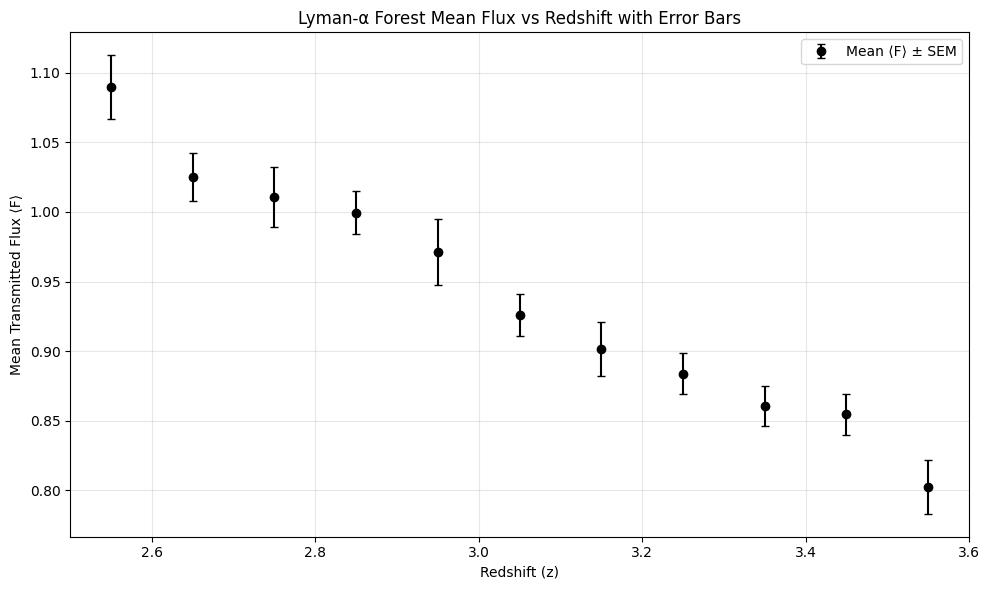

In [ ]:
# GOAL OF THIS CODE BLOCK:

# Create a list to hold redshift + mean flux pairs
mean_flux_list = []

# Join predicted_df back to df_large to get redshifts
df_combined = pd.merge(predicted_df, df_large[['specobjid', 'redshift']], on='specobjid')

for idx, row in df_combined.iterrows():
    continuum = row[1:len(rest_wavelength_grid)+1].values.astype(float)
    z = row['redshift']

    # Get observed flux row from df_large
    obs_row = df_large[df_large['specobjid'] == row['specobjid']]
    if obs_row.empty:
        continue

    # Full observed flux row (already in df_large)
    obs_flux_values = obs_row.iloc[0][flux_cols].values.astype(float)

    # Corresponding wavelengths
    obs_wave = np.array([int(c.split('_')[1]) for c in flux_cols], dtype=float)
    rest_wave = obs_wave / (1.0 + z)

    # Interpolate onto standard rest-frame grid
    try:
        f_interp_obs = interp1d(rest_wave, obs_flux_values, kind='linear', bounds_error=False, fill_value=np.nan)
        obs_flux = f_interp_obs(rest_wavelength_grid)
    except Exception as e:
        continue

    # Example: Normalize both observed and continuum to same red-side median
    red_mask = (rest_wavelength_grid >= 1270) & (rest_wavelength_grid <= 1290)

    obs_norm = np.nanmedian(obs_flux[red_mask])
    cont_norm = np.nanmedian(continuum[red_mask])

    obs_flux /= obs_norm
    continuum /= cont_norm

    # Convert to rest frame
    wave_rest = rest_wavelength_grid

    # Mask for Lyman-α forest region: 1080–1160 Å
    forest_mask = (wave_rest >= 1080) & (wave_rest <= 1160)

    flux_forest = obs_flux[forest_mask]
    cont_forest = continuum[forest_mask]


    # Compute transmission F = F_obs / F_cont
    F = flux_forest / cont_forest

    # Sanity check before appending
    if np.any(np.isnan(F)) or len(F) == 0:
        continue

    mean_flux = np.nanmean(F)
    if not np.isfinite(mean_flux):
        continue

    # Store the mean transmission and redshift
    mean_flux_list.append((z, np.mean(F)))

# Convert to DataFrame
flux_df = pd.DataFrame(mean_flux_list, columns=['z', 'F'])

# Bin in redshift
z_bins = np.arange(2.4, 4.1, 0.1)
flux_df['z_bin'] = pd.cut(flux_df['z'], bins=z_bins, right=False)
mean_flux_by_z = flux_df.groupby('z_bin')['F'].mean().reset_index()
# Get the numeric center of each bin
mean_flux_by_z['z_center'] = mean_flux_by_z['z_bin'].apply(lambda x: x.left + 0.05)
grouped = flux_df.groupby('z_bin')['F']
mean_flux_by_z = grouped.mean().reset_index(name='F')
mean_flux_by_z['F_err'] = grouped.std().values / np.sqrt(grouped.count().values)
mean_flux_by_z['z_center'] = mean_flux_by_z['z_bin'].apply(lambda x: x.left + 0.05)


# -------------------------------
# Plot ⟨F⟩ vs redshift with error bars
# -------------------------------
plt.figure(figsize=(10, 6))
plt.errorbar(mean_flux_by_z['z_center'], mean_flux_by_z['F'],
             yerr=mean_flux_by_z['F_err'],
             fmt='o', capsize=3, color='black', label='Mean ⟨F⟩ ± SEM')

plt.xlabel('Redshift (z)')
plt.ylabel('Mean Transmitted Flux ⟨F⟩')
plt.title('Lyman-α Forest Mean Flux vs Redshift with Error Bars')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



# Plot a continua for an example quasar spectra from the large dataset

Similar to how we did for the training continua, we recreate and then plot a continua against its spectra to qualitatively confirm we are making them correctly. This plot also shows the locations of various emission lines, the Lyman-alpha forest, and the transmission flux.

✅ Figure saved as: example_flux_plot.png


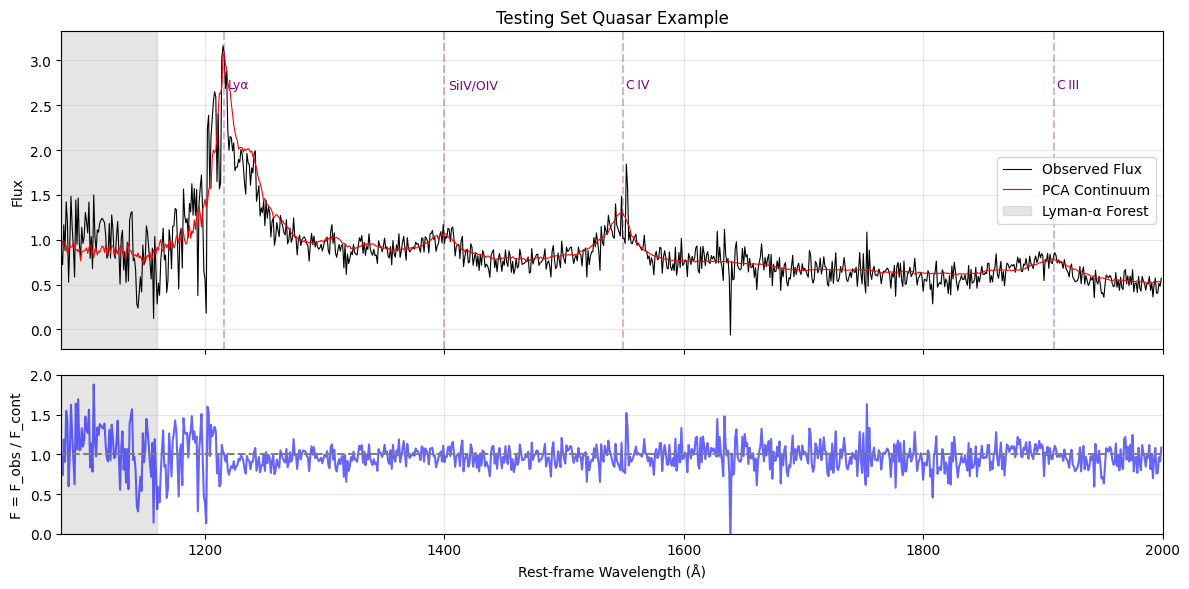

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np

# Define emission lines to overlay
emission_lines = {
    'Lyα': 1216,
    'SiIV/OIV': 1400,
    'C IV': 1549,
    'C III': 1909
}

def plot_qso_spectrum(index, df_combined, df_large, flux_cols, rest_wavelength_grid, save_path='qso_plot.png'):
    row = df_combined.iloc[index]
    z = row['redshift']
    continuum = row[1:len(rest_wavelength_grid)+1].values.astype(float)

    obs_row = df_large[df_large['specobjid'] == row['specobjid']]
    obs_flux_values = obs_row.iloc[0][flux_cols].values.astype(float)
    obs_wave = np.array([int(c.split('_')[1]) for c in flux_cols], dtype=float)
    rest_wave = obs_wave / (1.0 + z)

    f_interp = interp1d(rest_wave, obs_flux_values, kind='linear', bounds_error=False, fill_value=np.nan)
    obs_flux = f_interp(rest_wavelength_grid)
    # ✅ Normalize only the observed flux near 1280 Å
    norm_mask = (rest_wavelength_grid >= 1270) & (rest_wavelength_grid <= 1290)
    flux_norm = np.nanmedian(obs_flux[norm_mask])
    cont_norm = np.nanmedian(continuum[norm_mask])

    if not np.isfinite(flux_norm) or flux_norm <= 0:
        print(f"⚠️ Skipping {qso_name} due to bad normalization region.")
        return

    obs_flux /= flux_norm  # Normalize observed flux only
    continuum /= cont_norm  # Normalize continuum
    F = obs_flux / continuum

    # Plot
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    # Top: Observed + Continuum
    axs[0].plot(rest_wavelength_grid, obs_flux, label="Observed Flux", color='black', linewidth=0.8)
    axs[0].plot(rest_wavelength_grid, continuum, label="PCA Continuum", color='red', linewidth=0.8)
    axs[0].axvspan(1080, 1160, color='gray', alpha=0.2, label="Lyman-α Forest")
    axs[0].set_ylabel("Flux")
    axs[0].set_title("Testing Set Quasar Example")
    axs[0].legend()
    axs[0].grid(True, alpha=0.3)

    # Overlay emission line labels
    for name, wl in emission_lines.items():
        axs[0].axvline(wl, color='purple', linestyle='--', alpha=0.3)
        axs[0].text(wl + 3, np.nanmax(obs_flux) * 0.85, name, color='purple', fontsize=9)

    # Bottom: Transmission
    axs[1].plot(rest_wavelength_grid, F, color='blue', alpha=0.6)
    axs[1].axvspan(1080, 1160, color='gray', alpha=0.2)
    axs[1].axhline(1.0, color='gray', linestyle='--')
    axs[1].set_xlabel("Rest-frame Wavelength (Å)")
    axs[1].set_ylabel("F = F_obs / F_cont")
    axs[1].set_ylim(0, 2)
    axs[1].grid(True, alpha=0.3)

    plt.xlim(1080, 2000)
    plt.tight_layout()

    # Save figure
    fig.savefig(save_path, dpi=300)
    print(f"✅ Figure saved as: {save_path}")
    plt.show()

# Example usage
plot_qso_spectrum(1, df_combined, df_large, flux_cols, rest_wavelength_grid, save_path='example_flux_plot.png')


# Compute RMSE for the test quasars

We compute the RMSE of our test quasars continua to filter out the outliers, so we can make an improved $\rm <F_{transmitted}>$ vs. z plot without any outliers.

In [ ]:
rmse_list = []

for idx, row in df_combined.iterrows():
    z = row['redshift']
    continuum = row[1:len(rest_wavelength_grid)+1].values.astype(float)

    # Get corresponding observed flux
    obs_row = df_large[df_large['specobjid'] == row['specobjid']]
    if obs_row.empty:
        continue

    obs_flux_values = obs_row.iloc[0][flux_cols].values.astype(float)
    obs_wave = np.array([int(c.split('_')[1]) for c in flux_cols], dtype=float)
    rest_wave = obs_wave / (1.0 + z)

    try:
        f_interp = interp1d(rest_wave, obs_flux_values, kind='linear', bounds_error=False, fill_value=np.nan)
        obs_flux = f_interp(rest_wavelength_grid)
    except Exception as e:
        continue

    # ✅ Normalize only the observed flux near 1280 Å
    norm_mask = (rest_wavelength_grid >= 1270) & (rest_wavelength_grid <= 1290)
    flux_norm = np.nanmedian(obs_flux[norm_mask])
    cont_norm = np.nanmedian(continuum[norm_mask])

    obs_flux /= flux_norm  # Normalize observed flux only
    continuum /= cont_norm  # Normalize continuum

    # Compute RMSE on red side
    red_mask = (rest_wavelength_grid >= 1280) & (rest_wavelength_grid <= 1500)
    residual = obs_flux[red_mask] - continuum[red_mask]
    rmse = np.sqrt(np.nanmean(residual**2))
    rmse_list.append(rmse)

print(f"✅ Evaluated RMSE for {len(rmse_list)} quasars.")


✅ Evaluated RMSE for 690 quasars.


# Create a histogram of the RMSEs and identify outliers based on a threshold

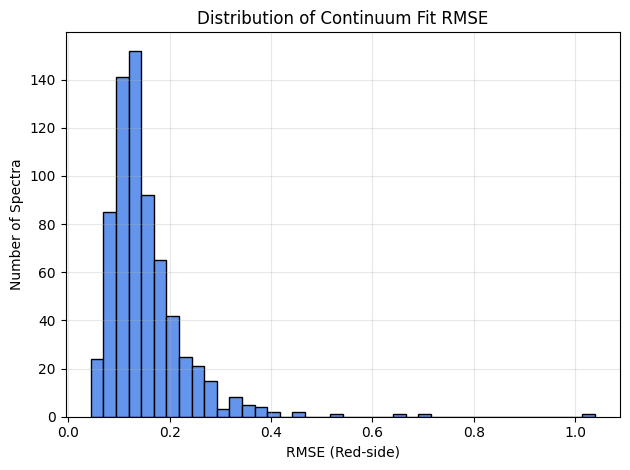

⚠️  114 outlier spectra with RMSE > 0.2


In [ ]:
plt.hist(rmse_list, bins=40, color='cornflowerblue', edgecolor='black')
plt.xlabel("RMSE (Red-side)")
plt.ylabel("Number of Spectra")
plt.title("Distribution of Continuum Fit RMSE")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

threshold = 0.2
outliers = [i for i, val in enumerate(rmse_list) if val > threshold]
print(f"⚠️  {len(outliers)} outlier spectra with RMSE > {threshold}")

# Recreate Paris fig 15 but this time filter out outliers

We filter out any continua with RMSE > 0.2 to recreate this plot. This filtered out 114 outliers, leaving us with 576 spectra. We also compute the transmission flux error where error = standard deviation of tramsitted flux values in bin / sqrt(numer of quasars in bin).

✅ Kept 576 spectra after filtering out 114 RMSE outliers.
✅ Computed ⟨F⟩ for 517 quasars.


<ipython-input-98-3c4b296f49bf>:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = flux_df.groupby('z_bin')['F']


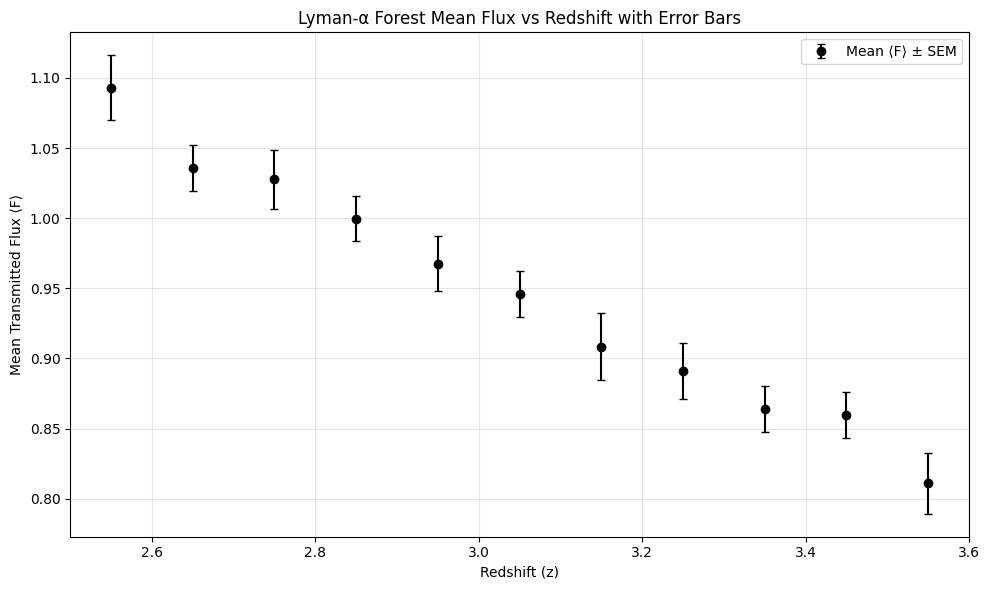

In [ ]:
# -------------------------------
# Filter out outlier spectra
# -------------------------------
threshold = 0.2
outliers = [i for i, val in enumerate(rmse_list) if val > threshold]

df_combined_filtered = df_combined.drop(index=outliers).reset_index(drop=True)
print(f"✅ Kept {len(df_combined_filtered)} spectra after filtering out {len(outliers)} RMSE outliers.")

# -------------------------------
# Compute ⟨F⟩ values per spectrum
# -------------------------------
mean_flux_list = []

for idx, row in df_combined_filtered.iterrows():
    continuum = row[1:len(rest_wavelength_grid)+1].values.astype(float)
    z = row['redshift']

    obs_row = df_large[df_large['specobjid'] == row['specobjid']]
    if obs_row.empty:
        continue

    obs_flux_values = obs_row.iloc[0][flux_cols].values.astype(float)
    obs_wave = np.array([int(c.split('_')[1]) for c in flux_cols], dtype=float)
    rest_wave = obs_wave / (1.0 + z)

    try:
        f_interp_obs = interp1d(rest_wave, obs_flux_values, kind='linear', bounds_error=False, fill_value=np.nan)
        obs_flux = f_interp_obs(rest_wavelength_grid)
    except Exception as e:
        continue

    # ✅ Normalize only the observed flux near 1280 Å
    norm_mask = (rest_wavelength_grid >= 1270) & (rest_wavelength_grid <= 1290)
    flux_norm = np.nanmedian(obs_flux[norm_mask])
    cont_norm = np.nanmedian(continuum[norm_mask])

    obs_flux /= flux_norm  # Normalize observed flux only
    continuum /= cont_norm  # Normalize continuum

    wave_rest = rest_wavelength_grid
    forest_mask = (wave_rest >= 1080) & (wave_rest <= 1160)
    if not np.any(forest_mask):
        continue

    flux_forest = obs_flux[forest_mask]
    cont_forest = continuum[forest_mask]

    cont_forest[cont_forest <= 0] = np.nan

    F = flux_forest / cont_forest

    if np.any(np.isnan(F)) or len(F) == 0:
        continue

    mean_flux = np.nanmean(F)
    if not np.isfinite(mean_flux):
        continue

    mean_flux_list.append((z, mean_flux))

print(f"✅ Computed ⟨F⟩ for {len(mean_flux_list)} quasars.")

# -------------------------------
# Group by redshift bin and compute mean + SEM
# -------------------------------
flux_df = pd.DataFrame(mean_flux_list, columns=['z', 'F'])

z_bins = np.arange(2.4, 4.1, 0.1)
flux_df['z_bin'] = pd.cut(flux_df['z'], bins=z_bins, right=False)

grouped = flux_df.groupby('z_bin')['F']
mean_flux_by_z = grouped.mean().reset_index(name='F')
mean_flux_by_z['F_err'] = grouped.std().values / np.sqrt(grouped.count().values)
mean_flux_by_z['z_center'] = mean_flux_by_z['z_bin'].apply(lambda x: x.left + 0.05)

# -------------------------------
# Plot ⟨F⟩ vs redshift with error bars
# -------------------------------
plt.figure(figsize=(10, 6))
plt.errorbar(mean_flux_by_z['z_center'], mean_flux_by_z['F'],
             yerr=mean_flux_by_z['F_err'],
             fmt='o', capsize=3, color='black', label='Mean ⟨F⟩ ± SEM')

plt.xlabel('Redshift (z)')
plt.ylabel('Mean Transmitted Flux ⟨F⟩')
plt.title('Lyman-α Forest Mean Flux vs Redshift with Error Bars')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Analysis and Conclusions

Following the steps laid out in the introduction, we create our projection matrix by performing PCA on high-quality quasar sectra from the SDSS. We then use this projection matrix on the training set (the rest of the quasar spectra from the SDSS). Looking at the example continuum for the testing set, we verify we can create a continuum that matches the general shape of the spectra. The continuum in the Lyman-α forest is slightly jagged, but it is very smooth in the red areas of the spectra.

After creating the continua and confirming we can create them qualitatively, we create an initial Lyman-α Forest Mean Flux vs. redshift chart for our new continua. We find the RMSE scores for each created continua. Using a threshold of RMSE > 0.2, we cut the outliers (114 total) and create a new, more accurate Lyman-α Forest Mean Flux vs. redshift plot. This meant we had about 576 continua for this plot.

After comparing both Paris' and our new Lyman-α Forest Mean Flux vs. redshift charts, we see the same general trend between ours and Paris' Fig 15 (see below). The mean flux has an inverse linear relationship with redshift. This shows that the flux in Lyman-α forest increases linearly with distance showing that more and more flux is absorbed.

Our plot is not exactly the same as Paris' but shows the same inverse relationship. The reason that our plot has different numbers than Paris' is because of how they find their contiua. Instead of using PCA like we did, they handfit the contiuum for each quasar to the peaks of the spectra. This means that their continua will be greater than our, as they more closely follow the peaks, while ours are more in the middle of the absorption lines of the forest. Thus, even though Paris et al. use the same quasars, due to the differences in how we make the continua, we get the same trend but systematically higher fluxes.

This analysis shows that we can use PCA to create quasar continua and to study the absorption Lyman-α forest. Specifically we can study how the transmitted flux in the Lyman-α forest evolved with redshift, which is one way to learn about the IGM.

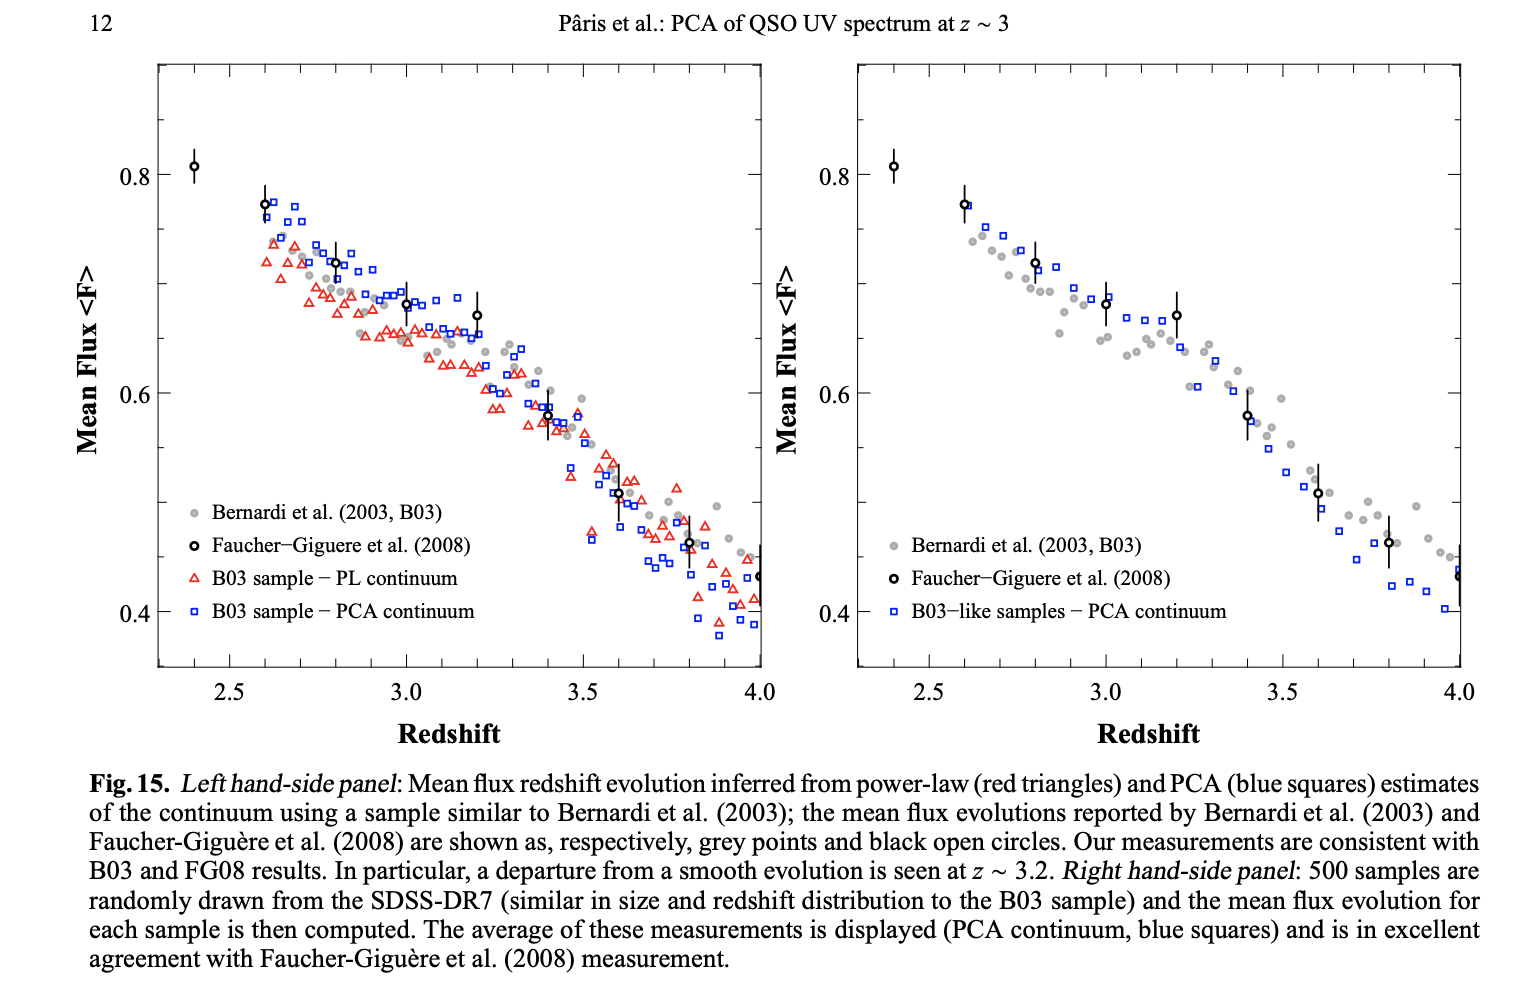

Above is the full Paris et al. Fig 15 including the caption. The most important point is that their data is the hollow black points with error bars will the smaller points without errors are from other surveys.

# Personal Contributions

Zavier - I acquired the data. I wrote all of the code. I made about 1/3 of the slides on the presentation. I presented about 1/3 of the slides.

Nick - I was the report lead, so I wrote the report. I made some slides for the presentation and I presented about 1/3 of the slides.

Lily - I worked on the presentation. I created the slides and wrote the outline for the presentation, and completed most slides (except Background, Conclusion, and References). I presented about 1/3 of the slides.

# AI Use Disclosure

Zavier - I used AI to write most of the code. I prompted ChatGPT (I recently got the pro level) by asking to recreate the series of steps described the Paris et al. 2018's paper. I used AI for the initial data acquisition (I had it give me a python script that would query SDSS for spectrum information of quasars with certain specifications).  I used AI to generate some images for the presentation slides.  

# References

[1] Paris et al. 2019: https://arxiv.org/pdf/1104.2024